In [25]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

from utils.preprocessing import combine_text, run_vader_analysis, preprocess_simple_tokenize, sentiment_to_number
from utils.tokenization import build_word2idx, tokenize_and_pad
from utils.mlp_model_vader import MLPWithMeanPooling, train_mlp, evaluate_mlp
import shap


In [14]:
raw_df = pd.read_csv("../data/realdonaldtrump.csv")
raw_df["full_text"] = raw_df.apply(combine_text, axis=1)
raw_df

,id,link,content,date,retweets,favorites,mentions,hashtags,full_text
0,1698308935,https://twitter.com/realDonaldTrump/status/169...,Be sure to tune in and watch Donald Trump on L...,2009-05-04 13:54:25,510,917,NaN,NaN,Be sure to tune in and watch Donald Trump on L...
1,1701461182,https://twitter.com/realDonaldTrump/status/170...,Donald Trump will be appearing on The View tom...,2009-05-04 20:00:10,34,267,NaN,NaN,Donald Trump will be appearing on The View tom...
2,1737479987,https://twitter.com/realDonaldTrump/status/173...,Donald Trump reads Top Ten Financial Tips on L...,2009-05-08 08:38:08,13,19,NaN,NaN,Donald Trump reads Top Ten Financial Tips on L...
3,1741160716,https://twitter.com/realDonaldTrump/status/174...,New Blog Post: Celebrity Apprentice Finale and...,2009-05-08 15:40:15,11,26,NaN,NaN,New Blog Post: Celebrity Apprentice Finale and...
4,1773561338,https://twitter.com/realDonaldTrump/status/177...,"""My persona will never be that of a wallflower...",2009-05-12 09:07:28,1375,1945,NaN,NaN,"""My persona will never be that of a wallflower..."
...,...,...,...,...,...,...,...,...,...
43347,1273405198698975232,https://twitter.com/realDonaldTrump/status/127...,Joe Biden was a TOTAL FAILURE in Government. H...,2020-06-17 19:00:32,23402,116377,NaN,NaN,Joe Biden was a TOTAL FAILURE in Government. H...
43348,1273408026968457216,https://twitter.com/realDonaldTrump/status/127...,Will be interviewed on @ seanhannity tonight a...,2020-06-17 19:11:47,11810,56659,@seanhannity,NaN,Will be interviewed on @ seanhannity tonight a...
43349,1273442195161387008,https://twitter.com/realDonaldTrump/status/127...,pic.twitter.com/3lm1spbU8X,2020-06-17 21:27:33,4959,19344,NaN,NaN,pic.twitter.com/3lm1spbU8X
43350,1273442469066276864,https://twitter.com/realDonaldTrump/status/127...,pic.twitter.com/vpCE5MadUz,2020-06-17 21:28:38,4627,17022,NaN,NaN,pic.twitter.com/vpCE5MadUz


In [15]:
# vader_df = run_vader_analysis(raw_df)
vader_df = pd.read_csv("../data/vader_sentiment.csv")

In [16]:
vader_df

,vader_clean,vader_sentiment_label,vader_numeric
0,Be sure to tune in and watch Donald Trump on L...,positive,1
1,Donald Trump will be appearing on The View tom...,positive,1
2,Donald Trump reads Top Ten Financial Tips on L...,positive,1
3,New Blog Post: Celebrity Apprentice Finale and...,neutral,0
4,"""My persona will never be that of a wallflower...",neutral,0
...,...,...,...
43347,Joe Biden was a TOTAL FAILURE in Government. H...,negative,2
43348,Will be interviewed on seanhannity tonight at ...,positive,1
43349,pic.twitter.com/3lm1spbU8X,neutral,0
43350,pic.twitter.com/vpCE5MadUz,neutral,0


/var/folders/hj/clr6h68n2d707cr8j0dzy2m80000gn/T/ipykernel_62732/2838543723.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


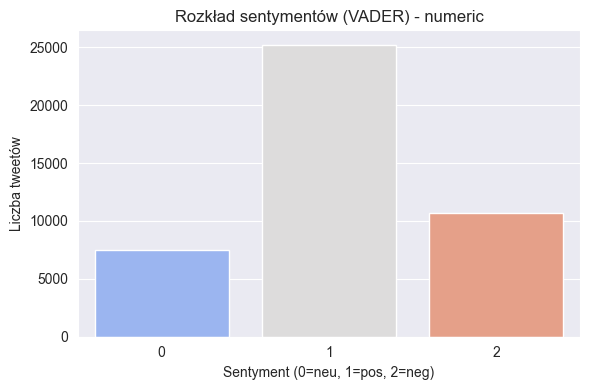

Neutral (0): 7466
Positive (1): 25191
Negative (2): 10695


In [17]:
plt.figure(figsize=(6, 4))
sns.countplot(
    data=vader_df,
    x="vader_numeric",
    palette="coolwarm"
)
plt.title("Rozkład sentymentów (VADER) - numeric")
plt.xlabel("Sentyment (0=neu, 1=pos, 2=neg)")
plt.ylabel("Liczba tweetów")
plt.tight_layout()
plt.show()

print("Neutral (0):", (vader_df["vader_numeric"] == 0).sum())
print("Positive (1):", (vader_df["vader_numeric"] == 1).sum())
print("Negative (2):", (vader_df["vader_numeric"] == 2).sum())



In [18]:
# vader_df.to_csv("../data/vader_sentiment.csv", index=False)
# print("Zapisano: data/vader_sentiment.csv")

In [19]:
vader_df["text"] = raw_df["full_text"].apply(preprocess_simple_tokenize)
vader_df["label"] = vader_df["vader_sentiment_label"].map(sentiment_to_number)
vader_df

,vader_clean,vader_sentiment_label,vader_numeric,text,label
0,Be sure to tune in and watch Donald Trump on L...,positive,1,be sure to tune in and watch donald trump on l...,1
1,Donald Trump will be appearing on The View tom...,positive,1,donald trump will be appearing on the view tom...,1
2,Donald Trump reads Top Ten Financial Tips on L...,positive,1,donald trump reads top ten financial tips on l...,1
3,New Blog Post: Celebrity Apprentice Finale and...,neutral,0,new blog post celebrity apprentice finale and ...,0
4,"""My persona will never be that of a wallflower...",neutral,0,my persona will never be that of a wallflower ...,0
...,...,...,...,...,...
43347,Joe Biden was a TOTAL FAILURE in Government. H...,negative,2,joe biden was a total failure in government he...,2
43348,Will be interviewed on seanhannity tonight at ...,positive,1,will be interviewed on seanhannity tonight at ...,1
43349,pic.twitter.com/3lm1spbU8X,neutral,0,pictwittercom3lm1spbu8x,0
43350,pic.twitter.com/vpCE5MadUz,neutral,0,pictwittercomvpce5maduz,0


In [20]:
word2idx = build_word2idx(vader_df["text"])
X_tensor = tokenize_and_pad(vader_df["text"], word2idx)
y_tensor = torch.tensor(vader_df["label"].values, dtype=torch.long)

In [21]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
for train_idx, test_idx in sss.split(np.zeros(len(y_tensor)), y_tensor.numpy()):
    X_train, X_test = X_tensor[train_idx], X_tensor[test_idx]
    y_train, y_test = y_tensor[train_idx], y_tensor[test_idx]

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=64, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=64)


In [22]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
model = MLPWithMeanPooling(len(word2idx), embedding_dim=100, hidden_dims=[32, 16], output_dim=3, pad_idx=word2idx['<pad>']).to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

l1_lambda = 1e-4

train_losses, train_accuracies = [], []
for epoch in range(20):
    loss, acc = train_mlp(model, train_loader, optimizer, criterion, device, l1_lambda=l1_lambda)
    train_losses.append(loss)
    train_accuracies.append(acc)
    print(f"Epoch {epoch+1}: Loss={loss:.4f}, Accuracy={acc:.4f}")

Epoch 1: Loss=326.6342, Accuracy=0.5487
Epoch 2: Loss=155.6500, Accuracy=0.5947
Epoch 3: Loss=68.4992, Accuracy=0.6137
Epoch 4: Loss=27.7229, Accuracy=0.6367
Epoch 5: Loss=10.5255, Accuracy=0.6595
Epoch 6: Loss=4.0703, Accuracy=0.6873
Epoch 7: Loss=1.9463, Accuracy=0.7125
Epoch 8: Loss=1.3024, Accuracy=0.7278
Epoch 9: Loss=1.1270, Accuracy=0.7486
Epoch 10: Loss=1.0744, Accuracy=0.7584
Epoch 11: Loss=1.0507, Accuracy=0.7727
Epoch 12: Loss=1.0099, Accuracy=0.7849
Epoch 13: Loss=0.9986, Accuracy=0.7954
Epoch 14: Loss=0.9839, Accuracy=0.8000
Epoch 15: Loss=0.9650, Accuracy=0.8060
Epoch 16: Loss=0.9411, Accuracy=0.8183
Epoch 17: Loss=0.9376, Accuracy=0.8168
Epoch 18: Loss=0.9098, Accuracy=0.8215
Epoch 19: Loss=0.9103, Accuracy=0.8244
Epoch 20: Loss=0.8920, Accuracy=0.8275



Test Loss: 0.3814
Test Accuracy: 0.8581

Classification Report:
              precision    recall  f1-score   support

    negative       0.76      0.85      0.80      1493
     neutral       0.92      0.89      0.91      5039
    positive       0.78      0.78      0.78      2139

    accuracy                           0.86      8671
   macro avg       0.82      0.84      0.83      8671
weighted avg       0.86      0.86      0.86      8671


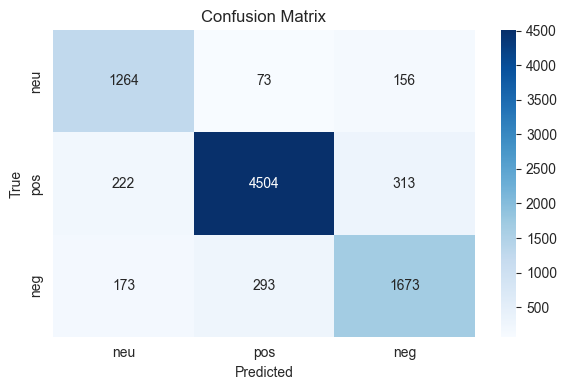

In [23]:
test_loss, test_acc, y_pred, y_true = evaluate_mlp(model, test_loader, criterion, device)

print(f"\nTest Loss: {test_loss:.4f}\nTest Accuracy: {test_acc:.4f}")
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=["negative", "neutral", "positive"]))

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt="d", cmap="Blues",
            xticklabels=["neu", "pos", "neg"], yticklabels=["neu", "pos", "neg"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()



Train Loss: 0.3073
Train Accuracy: 0.8999

Classification Report (Train):
              precision    recall  f1-score   support

    negative       0.85      0.89      0.87      5973
     neutral       0.94      0.92      0.93     20152
    positive       0.84      0.86      0.85      8556

    accuracy                           0.90     34681
   macro avg       0.88      0.89      0.88     34681
weighted avg       0.90      0.90      0.90     34681


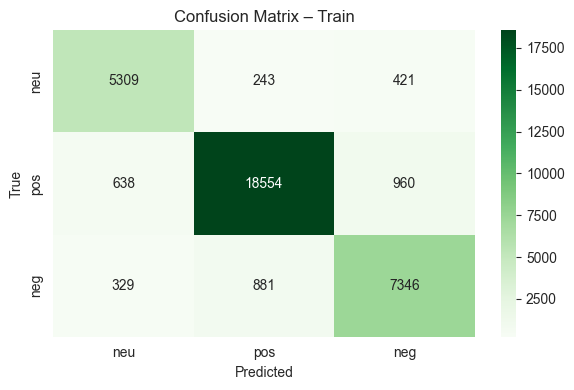

In [24]:
train_loss, train_acc, y_pred_train, y_true_train = evaluate_mlp(model, train_loader, criterion, device)

print(f"\nTrain Loss: {train_loss:.4f}\nTrain Accuracy: {train_acc:.4f}")
print("\nClassification Report (Train):")
print(classification_report(y_true_train, y_pred_train, target_names=["negative", "neutral", "positive"]))

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_true_train, y_pred_train), annot=True, fmt="d", cmap="Greens",
            xticklabels=["neu", "pos", "neg"], yticklabels=["neu", "pos", "neg"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix – Train")
plt.tight_layout()
plt.show()

AttributeError: 'MLPWithMeanPooling' object has no attribute 'mean_pooling'